## Plotting the scheduling example in the motivation section

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

In [2]:
aspect = 1.4
height = 2.5
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}

params = {'axes.labelsize': 'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [3]:
PERIOD = 120

A="dusseldorf"
a_init_acc = 65
a_cfgs = {
    "high": {"train_time": 85, "acc": 75},
    "low": {"train_time": 65, "acc": 70},
    "no": {"train_time": 0, "acc": a_init_acc}
}

a_window2_cfgs = {
    "high": {"train_time": 90, "acc": 95},
    "low": {"train_time": 40, "acc": 90},
    "no": {"train_time": 0, "acc": a_init_acc}
}

B="aachen"
b_init_acc = 50
b_cfgs = {
    "high": {"train_time": 80, "acc": 90},
    "low": {"train_time": 50, "acc": 85},
    "no": {"train_time": 0, "acc": b_init_acc}
}


b_window2_cfgs = {
    "high": {"train_time": 80, "acc": 98},
    "low": {"train_time": 70, "acc": 90},
    "no": {"train_time": 0, "acc": b_init_acc}
}

INF_RES_REQ = 1

PREPEND_SEC = 10

TOTAL_GPUS = 3

In [4]:
# Final configs as of 02/02, before ion's changes.

# PERIOD = 120

# A="dusseldorf"
# a_init_acc = 65
# a_cfgs = {
#     "high": {"train_time": 85, "acc": 75},
#     "low": {"train_time": 65, "acc": 70},
#     "no": {"train_time": 0, "acc": a_init_acc}
# }

# a_window2_cfgs = {
#     "high": {"train_time": 90, "acc": 95},
#     "low": {"train_time": 40, "acc": 90},
#     "no": {"train_time": 0, "acc": a_init_acc}
# }

# B="aachen"
# b_init_acc = 20
# b_cfgs = {
#     "high": {"train_time": 80, "acc": 90},
#     "low": {"train_time": 50, "acc": 85},
#     "no": {"train_time": 0, "acc": b_init_acc}
# }


# b_window2_cfgs = {
#     "high": {"train_time": 80, "acc": 98},
#     "low": {"train_time": 70, "acc": 90},
#     "no": {"train_time": 0, "acc": b_init_acc}
# }

# INF_RES_REQ = 1

# PREPEND_SEC = 10

# TOTAL_GPUS = 3

# Baseline

In [5]:
def add_noise(data, stddev=1.1):
    new_data = []
    for d in data:
        if stddev is None:
            stddev = d*0.05
        noised = np.random.normal(d, stddev)
        new_data.append(noised)
    return new_data

In [6]:
def run3(a_cfg, b_cfg, a_start_acc, b_start_acc, a_res_alloc=1, b_res_alloc=1, a_inference_split=0.5, b_inference_split=0.5, max_inference_res=INF_RES_REQ,
         smart_inference=True):
    # When b finishes first and relinquishes resources
    a_final_acc = a_cfg["acc"]
    b_final_acc = b_cfg["acc"]
    
    if smart_inference:
        a_inference_res = min(a_inference_split*(a_res_alloc), max_inference_res)
        b_inference_res = min(b_inference_split*(b_res_alloc), max_inference_res)
    else:
        a_inference_res = a_inference_split*(a_res_alloc)
        b_inference_res = b_inference_split*(b_res_alloc)
    a_train_res = a_res_alloc - a_inference_res
    b_train_res = b_res_alloc - b_inference_res

    a_completion_time = a_cfg["train_time"]/a_train_res
    b_completion_time = b_cfg["train_time"]/b_train_res

    print("A inf res: {}. A train res {}.".format(a_inference_res, a_train_res))
    print("B inf res: {}. B train res {}.".format(b_inference_res, b_train_res))
    print("A completion time: {}. B completion time {}.".format(a_completion_time, b_completion_time))

    b_inference_acc = []
    b_acc_redn_factor = inference_acc_slowdown(b_inference_res)
    relinquished_res = b_res_alloc
    assert relinquished_res >= 0
    print("B will relinquish {}".format(relinquished_res))
    b_inf_added_res = relinquished_res/3
    b_new_inf_res = b_inference_res + b_inf_added_res
    b_acc_redn_factor_posttrain = inference_acc_slowdown(b_new_inf_res) # All res for b
    print("B inference speed factors: {}, posttrain: {}".format(b_acc_redn_factor, b_acc_redn_factor_posttrain))
    for i in range(0, int(b_completion_time)):
        b_inference_acc.append(b_acc_redn_factor*b_start_acc)
    for i in range(int(b_completion_time), PERIOD):
        b_inference_acc.append(b_acc_redn_factor_posttrain*b_final_acc)
        
    # Compute inference accuracy curves
    a_inference_acc = []
    a_acc_redn_factor = inference_acc_slowdown(a_inference_res)
    a_acc_redn_factor_postb = inference_acc_slowdown(a_inference_res + relinquished_res/3)
    print("A inference speed factor: {}".format(a_acc_redn_factor))
    # till b is completed
    for i in range(0, int(b_completion_time)):
        a_inference_acc.append(a_acc_redn_factor*a_start_acc)
    # Till a is completed
    remaining_wall_time = (int(a_completion_time) - int(b_completion_time))*a_train_res
    new_remaining_res_time = int(remaining_wall_time/(a_train_res + relinquished_res))
    print("Remaining wall time: {}, new_remaining_res_time: {}".format(remaining_wall_time, new_remaining_res_time))
    new_completion_time = int(b_completion_time)+new_remaining_res_time
    a_acc_redn_factor_posttrain = inference_acc_slowdown(max_inference_res)
    print("A actual completion time: {}".format(new_completion_time))
    for i in range(int(b_completion_time), min(new_completion_time, PERIOD)):
        a_inference_acc.append(a_acc_redn_factor_postb*a_start_acc)    
    for i in range(int(b_completion_time)+new_remaining_res_time, PERIOD):
        a_inference_acc.append(a_acc_redn_factor_posttrain*a_final_acc)

    print("Done. a_mean_acc: {}. b_mean_acc: {}. Overall mean acc: {}".format(np.mean(a_inference_acc),
                                                                              np.mean(b_inference_acc),
                                                                             (np.mean(a_inference_acc) + 
                                                                              np.mean(b_inference_acc))/2))
  
#   a_final_acc_data, a_time_data, b_final_acc_data, b_time_data = prepend_preinference(a_inference_acc, a_start_acc, b_inference_acc, b_start_acc, prepend_sec)

    a_final_acc_data = add_noise(a_inference_acc, stddev=1.1)
    b_final_acc_data = add_noise(b_inference_acc, stddev=1.1)
    a_time_data = range(0, len(a_final_acc_data))
    b_time_data = range(0, len(b_final_acc_data))
    
    return a_final_acc_data, a_time_data, b_final_acc_data, b_time_data

In [7]:
def inference_acc_slowdown(res, base_res=INF_RES_REQ, k=1):
    return min(1/((base_res/res)/k), 1)
    
def run2(a_cfg, b_cfg, a_start_acc, b_start_acc, a_res_alloc=1, b_res_alloc=1, a_inference_split=0.5, b_inference_split=0.5, max_inference_res=INF_RES_REQ,
         smart_inference=True):
    # When b finishes first and relinquishes resources
    a_final_acc = a_cfg["acc"]
    b_final_acc = b_cfg["acc"]
    
    if smart_inference:
        a_inference_res = min(a_inference_split*(a_res_alloc), max_inference_res)
        b_inference_res = min(b_inference_split*(b_res_alloc), max_inference_res)
    else:
        a_inference_res = a_inference_split*(a_res_alloc)
        b_inference_res = b_inference_split*(b_res_alloc)
    a_train_res = a_res_alloc - a_inference_res
    b_train_res = b_res_alloc - b_inference_res

    a_completion_time = a_cfg["train_time"]/a_train_res
    b_completion_time = b_cfg["train_time"]/b_train_res

    print("A inf res: {}. A train res {}.".format(a_inference_res, a_train_res))
    print("B inf res: {}. B train res {}.".format(b_inference_res, b_train_res))
    print("A completion time: {}. B completion time {}.".format(a_completion_time, b_completion_time))

    b_inference_acc = []
    b_acc_redn_factor = inference_acc_slowdown(b_inference_res)
    relinquished_res = b_res_alloc - max_inference_res
    assert relinquished_res >= 0
    print("B will relinquish {}".format(relinquished_res))
    b_acc_redn_factor_posttrain = inference_acc_slowdown(max_inference_res) # All res for b
    print("B inference speed factors: {}, posttrain: {}".format(b_acc_redn_factor, b_acc_redn_factor_posttrain))
    for i in range(0, int(b_completion_time)):
        b_inference_acc.append(b_acc_redn_factor*b_start_acc)
    for i in range(int(b_completion_time), PERIOD):
        b_inference_acc.append(b_acc_redn_factor_posttrain*b_final_acc)
        
    # Compute inference accuracy curves
    a_inference_acc = []
    a_acc_redn_factor = inference_acc_slowdown(a_inference_res)
    print("A inference speed factor: {}".format(a_acc_redn_factor))
    # till b is completed
    for i in range(0, int(b_completion_time)):
        a_inference_acc.append(a_acc_redn_factor*a_start_acc)
    # Till a is completed
    remaining_wall_time = (int(a_completion_time) - int(b_completion_time))*a_train_res
    new_remaining_res_time = int(remaining_wall_time/(a_train_res + relinquished_res))
    print("Remaining wall time: {}, new_remaining_res_time: {}".format(remaining_wall_time, new_remaining_res_time))
    new_completion_time = int(b_completion_time)+new_remaining_res_time
    #a_acc_redn_factor = inference_acc_slowdown(a_inference_res + relinquished_res)
    a_acc_redn_factor_posttrain = inference_acc_slowdown(a_res_alloc + relinquished_res)
    print("A actual completion time: {}".format(new_completion_time))
    for i in range(int(b_completion_time), min(new_completion_time, PERIOD)):
        a_inference_acc.append(a_acc_redn_factor*a_start_acc)    
    for i in range(int(b_completion_time)+new_remaining_res_time, PERIOD):
        a_inference_acc.append(a_acc_redn_factor_posttrain*a_final_acc)

    print("Done. a_mean_acc: {}. b_mean_acc: {}. Overall mean acc: {}".format(np.mean(a_inference_acc),
                                                                              np.mean(b_inference_acc),
                                                                             (np.mean(a_inference_acc) + 
                                                                              np.mean(b_inference_acc))/2))
  
#   a_final_acc_data, a_time_data, b_final_acc_data, b_time_data = prepend_preinference(a_inference_acc, a_start_acc, b_inference_acc, b_start_acc, prepend_sec)

    a_final_acc_data = add_noise(a_inference_acc, stddev=1.1)
    b_final_acc_data = add_noise(b_inference_acc, stddev=1.1)
    a_time_data = range(0, len(a_final_acc_data))
    b_time_data = range(0, len(b_final_acc_data))
    
    return a_final_acc_data, a_time_data, b_final_acc_data, b_time_data

def prepend_preinference(a_inference_acc_data, a_start_acc, b_inference_acc_data, b_start_acc, prepend_sec, noise_stddev=1.1):
    a_pre_inference_acc = add_noise([a_start_acc] * prepend_sec, noise_stddev)
    a_final_acc_data = a_pre_inference_acc + a_inference_acc_data
    a_time_data = list(range(-1*prepend_sec, len(a_inference_acc_data)))
    
    b_pre_inference_acc = add_noise([b_start_acc] * prepend_sec, noise_stddev)
    b_final_acc_data = b_pre_inference_acc + b_inference_acc_data
    b_time_data = range(-1*prepend_sec, len(b_inference_acc_data))
    
    return a_final_acc_data, a_time_data, b_final_acc_data, b_time_data

No handles with labels found to put in legend.


A inf res: 1.0. A train res 1.0.
B inf res: 1.0. B train res 1.0.
A completion time: 0.0. B completion time 0.0.
B will relinquish 1
B inference speed factors: 1.0, posttrain: 1.0
A inference speed factor: 1.0
Remaining wall time: 0.0, new_remaining_res_time: 0
A actual completion time: 0
Done. a_mean_acc: 65.0. b_mean_acc: 50.0. Overall mean acc: 57.5
A inf res: 1.0. A train res 1.0.
B inf res: 1.0. B train res 1.0.
A completion time: 0.0. B completion time 0.0.
B will relinquish 1
B inference speed factors: 1.0, posttrain: 1.0
A inference speed factor: 1.0
Remaining wall time: 0.0, new_remaining_res_time: 0
A actual completion time: 0
Done. a_mean_acc: 65.0. b_mean_acc: 50.0. Overall mean acc: 57.5


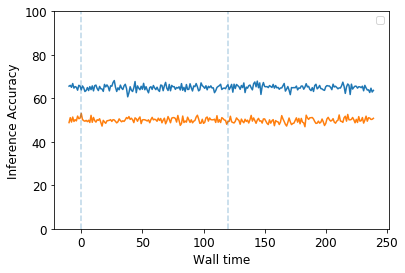

In [79]:
# No retraining

a_window1_data, _, b_window1_data, _ = run2(a_cfgs["no"], b_cfgs["no"], a_init_acc, b_init_acc, a_res_alloc=2, b_res_alloc=2)

new_acc_a = a_cfgs["no"]["acc"]
new_acc_b = b_cfgs["no"]["acc"]

a_window2_data, _, b_window2_data, _ = run2(a_cfgs["no"], b_cfgs["no"], new_acc_a, new_acc_b, a_res_alloc=2, b_res_alloc=2)

a_final_acc_data = a_window1_data + a_window2_data
b_final_acc_data = b_window1_data + b_window2_data

a_final_acc_data, a_time_data, b_final_acc_data, b_time_data = prepend_preinference(a_final_acc_data, a_init_acc, b_final_acc_data, b_init_acc, prepend_sec=10)

plt.plot(a_time_data, a_final_acc_data)
plt.plot(b_time_data, b_final_acc_data)
plt.legend()
plt.ylim([0,100])
plt.xlabel("Wall time")
plt.ylabel("Inference Accuracy")

plt.axvline(x=0, ls='--', alpha=0.3)
plt.axvline(x=PERIOD, ls='--', alpha=0.3)

A inf res: 0.75. A train res 0.75.
B inf res: 0.75. B train res 0.75.
A completion time: 113.33333333333333. B completion time 106.66666666666667.
B will relinquish 1.5
B inference speed factors: 0.75, posttrain: 1
A inference speed factor: 0.75
Remaining wall time: 5.25, new_remaining_res_time: 2
A actual completion time: 108
Done. a_mean_acc: 51.645833333333336. b_mean_acc: 43.625. Overall mean acc: 47.63541666666667
A inf res: 0.75. A train res 0.75.
B inf res: 0.75. B train res 0.75.
A completion time: 120.0. B completion time 106.66666666666667.
B will relinquish 1.5
B inference speed factors: 0.75, posttrain: 1
A inference speed factor: 0.75
Remaining wall time: 10.5, new_remaining_res_time: 4
A actual completion time: 110
Done. a_mean_acc: 60.104166666666664. b_mean_acc: 71.05833333333334. Overall mean acc: 65.58125
Camera A t=0 to t=120s mean acc: 51.45
Camera A t=120 to t=240s mean acc: 60.17
Camera A total mean (t=0 to 240s): 55.81

Camera B t=0 to t=120s mean acc: 43.67
Came

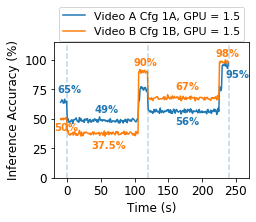

In [13]:
# Fair sharing and picking highest acc hyperparams

a_window1_data, _, b_window1_data, _ = run3(a_cfgs["high"], b_cfgs["high"], a_init_acc, b_init_acc,
                                                                    a_res_alloc=1.5, b_res_alloc=1.5)

new_acc_a = a_cfgs["high"]["acc"]
new_acc_b = b_cfgs["high"]["acc"]

a_window2_data, _, b_window2_data, _ = run3(a_window2_cfgs["high"], b_window2_cfgs["high"], new_acc_a, new_acc_b,
                                                                    a_res_alloc=1.5, b_res_alloc=1.5)

a_final_acc_data = a_window1_data + a_window2_data
b_final_acc_data = b_window1_data + b_window2_data


a_plot_acc_data, a_time_data, b_plot_acc_data, b_time_data = prepend_preinference(a_final_acc_data, a_init_acc, b_final_acc_data, b_init_acc, prepend_sec=10)

title = "Fair scheduler baseline, eventual best accuracy cfgs"
labelA = "Video A Cfg 1A, GPU = 1.5"
labelB = "Video B Cfg 1B, GPU = 1.5"

plt.figure(figsize=[height*aspect,height])
plt.plot(a_time_data, a_plot_acc_data, label=labelA)
plt.plot(b_time_data, b_plot_acc_data, label=labelB)
#plt.legend()
lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), prop={'size': 11})
plt.ylim([0,115])
plt.xlim([-20,PERIOD*2 + 30])
#plt.title(title + " Mean Acc: {}".format((np.mean(a_final_acc_data) + np.mean(b_final_acc_data))/2))
plt.xlabel("Time (s)")
plt.ylabel("Inference Accuracy (%)")
plt.xticks(range(0,270,50))

plt.axvline(x=0, ls='--', alpha=0.3)
plt.axvline(x=PERIOD, ls='--', alpha=0.3)
plt.axvline(x=PERIOD*2, ls='--', alpha=0.3)

plt.text(-15, 72, r'65%', fontsize='medium', color='C0', fontweight='bold')
plt.text(40, 55, r'49%', fontsize='medium', color='C0', fontweight='bold')
plt.text(160, 45, r'56%', fontsize='medium', color='C0', fontweight='bold')
plt.text(235, 85, r'95%', fontsize='medium', color='C0', fontweight='bold')


plt.text(-20, 40, r'50%', fontsize='medium', color='C1', fontweight='bold')
plt.text(35, 25, r'37.5%', fontsize='medium', color='C1', fontweight='bold')
plt.text(98, 95, r'90%', fontsize='medium', color='C1', fontweight='bold')
plt.text(160, 75, r'67%', fontsize='medium', color='C1', fontweight='bold')
plt.text(220, 103, r'98%', fontsize='medium', color='C1', fontweight='bold')


#plt.tight_layout()
plt.savefig("schedmot_multiwindow_eventual_best_cfgs.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

print("Camera A t=0 to t=120s mean acc: {:.2f}".format(np.mean(a_final_acc_data[0:120])))
print("Camera A t=120 to t=240s mean acc: {:.2f}".format(np.mean(a_final_acc_data[120:240])))
print("Camera A total mean (t=0 to 240s): {:.2f}\n".format(np.mean(a_final_acc_data[0:240])))


print("Camera B t=0 to t=120s mean acc: {:.2f}".format(np.mean(b_final_acc_data[0:120])))
print("Camera B t=120 to t=240s mean acc: {:.2f}".format(np.mean(b_final_acc_data[120:240])))
print("Camera B total mean (t=0 to 240s): {:.2f}".format(np.mean(b_final_acc_data[0:240])))

print("\nCamera A and B combined mean (t=0 to 240s): {:.2f}".format(np.mean(a_final_acc_data[0:240] + b_final_acc_data[0:240])))

A inf res: 0.75. A train res 0.75.
B inf res: 0.75. B train res 0.75.
A completion time: 86.66666666666667. B completion time 66.66666666666667.
B will relinquish 0.5
B inference speed factors: 0.75, posttrain: 1.0
A inference speed factor: 0.75
Remaining wall time: 15.0, new_remaining_res_time: 12
A actual completion time: 78
Done. a_mean_acc: 56.1875. b_mean_acc: 58.875. Overall mean acc: 57.53125
A inf res: 0.75. A train res 0.75.
B inf res: 0.75. B train res 0.75.
A completion time: 93.33333333333333. B completion time 53.333333333333336.
B will relinquish 0.5
B inference speed factors: 0.75, posttrain: 1.0
A inference speed factor: 0.75
Remaining wall time: 30.0, new_remaining_res_time: 24
A actual completion time: 77
Done. a_mean_acc: 73.15625. b_mean_acc: 73.4375. Overall mean acc: 73.296875
Camera A t=0 to t=120s mean acc: 56.10
Camera A t=120 to t=240s mean acc: 73.26
Camera A total mean (t=0 to 240s): 64.68

Camera B t=0 to t=120s mean acc: 58.83
Camera B t=120 to t=240s mean

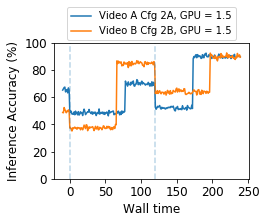

In [86]:
# Fair sharing and picking optimal hyperparams
a_window1_data, _, b_window1_data, _ = run2(a_cfgs["low"], b_cfgs["low"], a_init_acc, b_init_acc,
                                                                    a_res_alloc=1.5, b_res_alloc=1.5)

new_acc_a = a_cfgs["low"]["acc"]
new_acc_b = b_cfgs["low"]["acc"]

b_window2_data, _, a_window2_data, _ = run2(b_window2_cfgs["low"], a_window2_cfgs["low"], new_acc_b, new_acc_a,
                                                                    a_res_alloc=1.5, b_res_alloc=1.5)

a_final_acc_data = a_window1_data + a_window2_data
b_final_acc_data = b_window1_data + b_window2_data


a_plot_acc_data, a_time_data, b_plot_acc_data, b_time_data = prepend_preinference(a_final_acc_data, a_init_acc, b_final_acc_data, b_init_acc, prepend_sec=10)

title = "Fair scheduler baseline, optimal cfgs"
labelA = "Video A Cfg 2A, GPU = 1.5"
labelB = "Video B Cfg 2B, GPU = 1.5"

plt.figure(figsize=[height*aspect,height])
plt.plot(a_time_data, a_plot_acc_data, label=labelA)
plt.plot(b_time_data, b_plot_acc_data, label=labelB)
#plt.legend()
lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))
plt.ylim([0,100])
#plt.title(title + " Mean Acc: {}".format((np.mean(a_final_acc_data) + np.mean(b_final_acc_data))/2))
plt.xlabel("Wall time")
plt.ylabel("Inference Accuracy (%)")

plt.xticks(range(0,270,50))

plt.axvline(x=0, ls='--', alpha=0.3)
plt.axvline(x=PERIOD, ls='--', alpha=0.3)
#plt.tight_layout()
#plt.savefig("schedmot_multiwindow_optimal_cfgs.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

print("Camera A t=0 to t=120s mean acc: {:.2f}".format(np.mean(a_final_acc_data[0:120])))
print("Camera A t=120 to t=240s mean acc: {:.2f}".format(np.mean(a_final_acc_data[120:240])))
print("Camera A total mean (t=0 to 240s): {:.2f}\n".format(np.mean(a_final_acc_data[0:240])))


print("Camera B t=0 to t=120s mean acc: {:.2f}".format(np.mean(b_final_acc_data[0:120])))
print("Camera B t=120 to t=240s mean acc: {:.2f}".format(np.mean(b_final_acc_data[120:240])))
print("Camera B total mean (t=0 to 240s): {:.2f}".format(np.mean(b_final_acc_data[0:240])))

print("\nCamera A and B combined mean (t=0 to 240s): {:.2f}".format(np.mean(a_final_acc_data[0:240] + b_final_acc_data[0:240])))

A inf res: 0.99. A train res 0.010000000000000009.
B inf res: 0.8. B train res 1.2.
A completion time: 6499.9999999999945. B completion time 41.66666666666667.
B will relinquish 1
B inference speed factors: 0.8, posttrain: 1.0
A inference speed factor: 0.99
Remaining wall time: 64.58000000000006, new_remaining_res_time: 63
A actual completion time: 104
Done. a_mean_acc: 65.10333333333334. b_mean_acc: 69.625. Overall mean acc: 67.36416666666668
A inf res: 0.99. A train res 0.010000000000000009.
B inf res: 0.8. B train res 1.2.
A completion time: 6999.999999999994. B completion time 33.333333333333336.
B will relinquish 1
B inference speed factors: 0.8, posttrain: 1.0
A inference speed factor: 0.99
Remaining wall time: 69.66000000000007, new_remaining_res_time: 68
A actual completion time: 101
Done. a_mean_acc: 85.07624999999999. b_mean_acc: 80.65. Overall mean acc: 82.863125
Camera A t=0 to t=120s mean acc: 65.17
Camera A t=120 to t=240s mean acc: 80.72
Camera A total mean (t=0 to 240s)

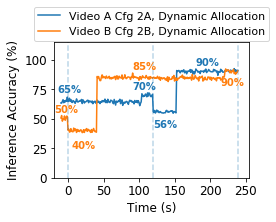

In [14]:
# Smart resource alloc and picking optimal hyperparams
a_window1_data, _, b_window1_data, _ = run2(a_cfgs["low"], b_cfgs["low"], a_init_acc, b_init_acc,
                                            a_inference_split=0.99, b_inference_split=0.4,
                                            a_res_alloc=1, b_res_alloc=2)

new_acc_a = a_cfgs["low"]["acc"]
new_acc_b = b_cfgs["low"]["acc"]

b_window2_data, _, a_window2_data, _ = run2(b_window2_cfgs["low"], a_window2_cfgs["low"], new_acc_b, new_acc_a,
                                            a_inference_split=0.99, b_inference_split=0.4,
                                            a_res_alloc=1, b_res_alloc=2)

a_final_acc_data = a_window1_data + a_window2_data
b_final_acc_data = b_window1_data + b_window2_data


a_plot_acc_data, a_time_data, b_plot_acc_data, b_time_data = prepend_preinference(a_final_acc_data, a_init_acc, b_final_acc_data, b_init_acc, prepend_sec=10)

title = "Smart resource alloc and picking optimal hyperparams"
labelA = "Video A Cfg 2A, Dynamic Allocation"
labelB = "Video B Cfg 2B, Dynamic Allocation"


plt.figure(figsize=[height*aspect,height])
plt.plot(a_time_data, a_plot_acc_data, label=labelA)
plt.plot(b_time_data, b_plot_acc_data, label=labelB)
#plt.legend()
lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), prop={'size': 11})

plt.ylim([0,115])
plt.xlim([-20,PERIOD*2 + 15])

#plt.title(title + " Mean Acc: {}".format((np.mean(a_final_acc_data) + np.mean(b_final_acc_data))/2))
plt.xlabel("Time (s)")
plt.ylabel("Inference Accuracy (%)")
plt.xticks(range(0,270,50))

plt.axvline(x=0, ls='--', alpha=0.3)
plt.axvline(x=PERIOD, ls='--', alpha=0.3)
plt.axvline(x=PERIOD*2, ls='--', alpha=0.3)


plt.text(-15, 72, r'65%', fontsize='medium', color='C0', fontweight='bold')
plt.text(90, 75, r'70%', fontsize='medium', color='C0', fontweight='bold')
plt.text(120, 43, r'56%', fontsize='medium', color='C0', fontweight='bold')
plt.text(180, 95, r'90%', fontsize='medium', color='C0', fontweight='bold')


plt.text(-20, 55, r'50%', fontsize='medium', color='C1', fontweight='bold')
plt.text(5, 25, r'40%', fontsize='medium', color='C1', fontweight='bold')
plt.text(90, 92, r'85%', fontsize='medium', color='C1', fontweight='bold')
plt.text(215, 78, r'90%', fontsize='medium', color='C1', fontweight='bold')

#plt.tight_layout()
plt.savefig("schedmot_multiwindow_prioritization_and_optimal_cfgs.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

print("Camera A t=0 to t=120s mean acc: {:.2f}".format(np.mean(a_final_acc_data[0:120])))
print("Camera A t=120 to t=240s mean acc: {:.2f}".format(np.mean(a_final_acc_data[120:240])))
print("Camera A total mean (t=0 to 240s): {:.2f}\n".format(np.mean(a_final_acc_data[0:240])))


print("Camera B t=0 to t=120s mean acc: {:.2f}".format(np.mean(b_final_acc_data[0:120])))
print("Camera B t=120 to t=240s mean acc: {:.2f}".format(np.mean(b_final_acc_data[120:240])))
print("Camera B total mean (t=0 to 240s): {:.2f}".format(np.mean(b_final_acc_data[0:240])))

print("\nCamera A and B combined mean (t=0 to 240s): {:.2f}".format(np.mean(a_final_acc_data[0:240] + b_final_acc_data[0:240])))

# PLot resource maps

106
226


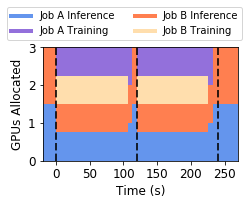

In [26]:
plt.figure(figsize=[height*aspect,height])

ax = plt.gca()
errorboxes = []

lw = 0
rects = []


A_TRAIN_TIME = 113-106
B_TRAIN_TIME = 106

B_PERIOD2_TRAIN_TIME = 106
A_PERIOD2_TRAIN_TIME = 114-106

# col_JobAInf = 'mediumblue'
# col_JobATrg = 'slateblue'
# col_JobBInf = 'firebrick'
# col_JobBTrg = 'orange'

col_JobAInf = 'cornflowerblue'
col_JobATrg = 'mediumpurple'
col_JobBInf = 'coral'
col_JobBTrg = 'navajowhite'

# Till start
rects.append(patches.Rectangle((-20,0), 20, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((-20,1.5), 20, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))

# Till B finishes
PHASE_START = 0
rects.append(patches.Rectangle((PHASE_START, 0), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 0.75), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 2.25), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till A finishes
PHASE_START += B_TRAIN_TIME
print(PHASE_START)
rects.append(patches.Rectangle((PHASE_START, 0), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1), A_TRAIN_TIME, 2,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.75), A_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 2), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till period 1 finishes
PHASE_START += A_TRAIN_TIME
REMAIN_TIME = PERIOD-PHASE_START
rects.append(patches.Rectangle((PHASE_START, 0), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))


# period 2 starts, till B finishes
PHASE_START += REMAIN_TIME
rects.append(patches.Rectangle((PHASE_START, 0), B_PERIOD2_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 0.75), B_PERIOD2_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), B_PERIOD2_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 2.25), B_PERIOD2_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Period 2, Till A finishes
PHASE_START += B_PERIOD2_TRAIN_TIME
print(PHASE_START)
rects.append(patches.Rectangle((PHASE_START, 0), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1), A_TRAIN_TIME, 2,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.75), A_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 2), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till period 2 finishes
PHASE_START += A_PERIOD2_TRAIN_TIME-1
REMAIN_TIME = PERIOD*2-PHASE_START+30
rects.append(patches.Rectangle((PHASE_START, 0), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))


# Add the patch to the Axes
for rect in rects:
    ax.add_patch(rect)
plt.xticks(range(0,270,50))
plt.xlim([-20,PERIOD*2+30])
plt.ylim([0,TOTAL_GPUS])

plt.axvline(x=0, ls='--', lw=2, alpha=0.8, color='black')
plt.axvline(x=PERIOD, ls='--', lw=2, alpha=0.8, color='black')
plt.axvline(x=PERIOD*2, ls='--', lw=2, alpha=0.8, color='black')


plt.xlabel('Time (s)')
plt.ylabel('GPUs Allocated')

custom_lines = [Line2D([0], [0], color=col_JobAInf, lw=4),
                Line2D([0], [0], color=col_JobATrg, lw=4),
                Line2D([0], [0], color=col_JobBInf, lw=4),
                Line2D([0], [0], color=col_JobBTrg, lw=4)]

lgd = ax.legend(custom_lines, ['Job A Inference', 'Job A Training', 'Job B Inference', 'Job B Training'],
         loc='upper center', bbox_to_anchor=(0.42, 1.4),
          ncol=2, prop={'size': 10})

plt.subplots_adjust(left=None, bottom=0.25, right=None, top=None, wspace=None, hspace=None)
plt.savefig("schedmot_res_eventual_best_cfgs.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

66
173.32999999999998


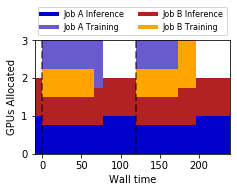

In [39]:
plt.figure(figsize=[height*aspect,height])

ax = plt.gca()
errorboxes = []

lw = 0
rects = []


A_TRAIN_TIME = 78-66
B_TRAIN_TIME = 66

A_PERIOD2_TRAIN_TIME = 53.33
B_PERIOD2_TRAIN_TIME = 77 - 53.33

col_JobAInf = 'mediumblue'
col_JobATrg = 'slateblue'
col_JobBInf = 'firebrick'
col_JobBTrg = 'orange'

# Till start
rects.append(patches.Rectangle((PREPEND_SEC*-1,0), PREPEND_SEC, 1,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PREPEND_SEC*-1,1), PREPEND_SEC, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))

# Till B finishes
PHASE_START = 0
rects.append(patches.Rectangle((PHASE_START, 0), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 0.75), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 2.25), B_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till A finishes
PHASE_START += B_TRAIN_TIME
print(PHASE_START)
rects.append(patches.Rectangle((PHASE_START, 0), A_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 0.75), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.75), A_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 1.75), A_TRAIN_TIME, 1.25,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till period 1 finishes
PHASE_START += A_TRAIN_TIME
REMAIN_TIME = PERIOD-PHASE_START
rects.append(patches.Rectangle((PHASE_START, 0), REMAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1), REMAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))


# period 2 starts, till A finishes
PHASE_START += REMAIN_TIME
rects.append(patches.Rectangle((PHASE_START, 0), A_PERIOD2_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 0.75), A_PERIOD2_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), A_PERIOD2_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 2.25), A_PERIOD2_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Period 2, Till B finishes
PHASE_START += A_PERIOD2_TRAIN_TIME
print(PHASE_START)
rects.append(patches.Rectangle((PHASE_START, 0), B_PERIOD2_TRAIN_TIME, 0.75,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 0.75), B_PERIOD2_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.75), B_PERIOD2_TRAIN_TIME, 1.25,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), B_PERIOD2_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till period 2 finishes
PHASE_START += B_PERIOD2_TRAIN_TIME
REMAIN_TIME = PERIOD*2-PHASE_START
rects.append(patches.Rectangle((PHASE_START, 0), REMAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1), REMAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))


# Add the patch to the Axes
for rect in rects:
    ax.add_patch(rect)
plt.xlim([-1*PREPEND_SEC,PERIOD*2])
plt.ylim([0,TOTAL_GPUS])

plt.axvline(x=0, ls='--', lw=2, alpha=0.5, color='black')
plt.axvline(x=PERIOD, ls='--', lw=2, alpha=0.5, color='black')

plt.xlabel('Wall time')
plt.ylabel('GPUs Allocated')

custom_lines = [Line2D([0], [0], color=col_JobAInf, lw=4),
                Line2D([0], [0], color=col_JobATrg, lw=4),
                Line2D([0], [0], color=col_JobBInf, lw=4),
                Line2D([0], [0], color=col_JobBTrg, lw=4)]
lgd = ax.legend(custom_lines, ['Job A Inference', 'Job A Training', 'Job B Inference', 'Job B Training'],
         loc='upper center', bbox_to_anchor=(0.5, 1.33),
          ncol=2, prop={'size': 8})

plt.subplots_adjust(left=None, bottom=0.25, right=None, top=None, wspace=None, hspace=None)

plt.savefig("schedmot_res_optimal_cfgs.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

142


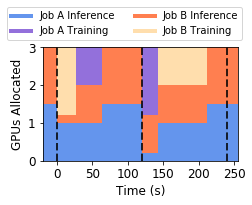

In [23]:

plt.figure(figsize=[height*aspect,height])

ax = plt.gca()
errorboxes = []

lw = 0
rects = []


A_TRAIN_TIME = 91 - 27
B_TRAIN_TIME = 27

A_PERIOD2_TRAIN_TIME = 22
B_PERIOD2_TRAIN_TIME = 91 - 22

col_JobAInf = 'cornflowerblue'
col_JobATrg = 'mediumpurple'
col_JobBInf = 'coral'
col_JobBTrg = 'navajowhite'


# Till start
rects.append(patches.Rectangle((-20,0), 20, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((-20,1.5), 20, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))

# Till B finishes
PHASE_START = 0
rects.append(patches.Rectangle((PHASE_START, 0), B_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1), B_TRAIN_TIME, 0.2,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.2), B_TRAIN_TIME, 1.8,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), B_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))


# Till A finishes
PHASE_START += B_TRAIN_TIME
rects.append(patches.Rectangle((PHASE_START, 0), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 2), A_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 2), A_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till period finishes
PHASE_START =+ A_TRAIN_TIME
REMAIN_TIME = PERIOD-PHASE_START
rects.append(patches.Rectangle((PHASE_START, 0), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))


# period 2 starts, till A finishes
PHASE_START += REMAIN_TIME
rects.append(patches.Rectangle((PHASE_START, 0), A_PERIOD2_TRAIN_TIME, 0.2,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 0.2), A_PERIOD2_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 1.2), A_PERIOD2_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 1.2), A_PERIOD2_TRAIN_TIME, 1.8,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Period 2, Till B finishes
PHASE_START += A_PERIOD2_TRAIN_TIME
print(PHASE_START)
rects.append(patches.Rectangle((PHASE_START, 0), B_PERIOD2_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1), B_PERIOD2_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 2), B_PERIOD2_TRAIN_TIME, 1,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), B_PERIOD2_TRAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))

# Till period 2 finishes
PHASE_START += B_PERIOD2_TRAIN_TIME
REMAIN_TIME = PERIOD*2-PHASE_START+15
rects.append(patches.Rectangle((PHASE_START, 0), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobAInf))
rects.append(patches.Rectangle((PHASE_START, 1.5), REMAIN_TIME, 1.5,linewidth=lw,edgecolor='black', facecolor=col_JobBInf))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobBTrg))
rects.append(patches.Rectangle((PHASE_START, 3), REMAIN_TIME, 0,linewidth=lw,edgecolor='black', facecolor=col_JobATrg))



# Add the patch to the Axes
for rect in rects:
    ax.add_patch(rect)
plt.xticks(range(0,270,50))
plt.xlim([-20,PERIOD*2+15])
plt.ylim([0,TOTAL_GPUS])

plt.axvline(x=0, ls='--', lw=2, alpha=0.8, color='black')
plt.axvline(x=PERIOD, ls='--', lw=2, alpha=0.8, color='black')
plt.axvline(x=PERIOD*2, ls='--', lw=2, alpha=0.8, color='black')


plt.xlabel('Time (s)')
plt.ylabel('GPUs Allocated')

custom_lines = [Line2D([0], [0], color=col_JobAInf, lw=4),
                Line2D([0], [0], color=col_JobATrg, lw=4),
                Line2D([0], [0], color=col_JobBInf, lw=4),
                Line2D([0], [0], color=col_JobBTrg, lw=4)]

lgd = ax.legend(custom_lines, ['Job A Inference', 'Job A Training', 'Job B Inference', 'Job B Training'],
         loc='upper center', bbox_to_anchor=(0.42, 1.4),
          ncol=2, prop={'size': 10})

plt.subplots_adjust(left=None, bottom=0.25, right=None, top=None, wspace=None, hspace=None)

plt.savefig("schedmot_res_prioritization_and_optimal_cfgs.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Appendix

A inf res: 0.75. A train res 0.75.
B inf res: 0.75. B train res 0.75.
A completion time: 113.33333333333333. B completion time 106.66666666666667.
B will relinquish 0.5
B inference speed factors: 0.75, posttrain: 1.0
A inference speed factor: 0.75
Remaining wall time: 5.25, new_remaining_res_time: 4
A actual completion time: 110
Done. a_mean_acc: 50.9375. b_mean_acc: 43.625. Overall mean acc: 47.28125
A inf res: 0.75. A train res 0.75.
B inf res: 0.75. B train res 0.75.
A completion time: 120.0. B completion time 106.66666666666667.
B will relinquish 0.5
B inference speed factors: 0.75, posttrain: 1.0
A inference speed factor: 0.75
Remaining wall time: 10.5, new_remaining_res_time: 8
A actual completion time: 114
Done. a_mean_acc: 58.1875. b_mean_acc: 71.05833333333334. Overall mean acc: 64.62291666666667
Camera A t=0 to t=120s mean acc: 50.72
Camera A t=120 to t=240s mean acc: 58.14
Camera A total mean (t=0 to 240s): 54.43

Camera B t=0 to t=120s mean acc: 43.60
Camera B t=120 to t=24

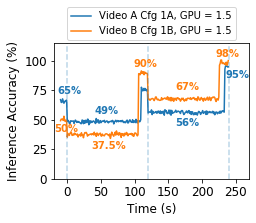

In [110]:
# Fair sharing and picking highest acc hyperparams

a_window1_data, _, b_window1_data, _ = run2(a_cfgs["high"], b_cfgs["high"], a_init_acc, b_init_acc,
                                                                    a_res_alloc=1.5, b_res_alloc=1.5)

new_acc_a = a_cfgs["high"]["acc"]
new_acc_b = b_cfgs["high"]["acc"]

a_window2_data, _, b_window2_data, _ = run2(a_window2_cfgs["high"], b_window2_cfgs["high"], new_acc_a, new_acc_b,
                                                                    a_res_alloc=1.5, b_res_alloc=1.5)

a_final_acc_data = a_window1_data + a_window2_data
b_final_acc_data = b_window1_data + b_window2_data


a_plot_acc_data, a_time_data, b_plot_acc_data, b_time_data = prepend_preinference(a_final_acc_data, a_init_acc, b_final_acc_data, b_init_acc, prepend_sec=10)

title = "Fair scheduler baseline, eventual best accuracy cfgs"
labelA = "Video A Cfg 1A, GPU = 1.5"
labelB = "Video B Cfg 1B, GPU = 1.5"

plt.figure(figsize=[height*aspect,height])
plt.plot(a_time_data, a_plot_acc_data, label=labelA)
plt.plot(b_time_data, b_plot_acc_data, label=labelB)
#plt.legend()
lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))
plt.ylim([0,115])
plt.xlim([-20,PERIOD*2 + 30])
#plt.title(title + " Mean Acc: {}".format((np.mean(a_final_acc_data) + np.mean(b_final_acc_data))/2))
plt.xlabel("Time (s)")
plt.ylabel("Inference Accuracy (%)")
plt.xticks(range(0,270,50))

plt.axvline(x=0, ls='--', alpha=0.3)
plt.axvline(x=PERIOD, ls='--', alpha=0.3)
plt.axvline(x=PERIOD*2, ls='--', alpha=0.3)

plt.text(-15, 72, r'65%', fontsize='medium', color='C0', fontweight='bold')
plt.text(40, 55, r'49%', fontsize='medium', color='C0', fontweight='bold')
plt.text(160, 45, r'56%', fontsize='medium', color='C0', fontweight='bold')
plt.text(235, 85, r'95%', fontsize='medium', color='C0', fontweight='bold')


plt.text(-20, 40, r'50%', fontsize='medium', color='C1', fontweight='bold')
plt.text(35, 25, r'37.5%', fontsize='medium', color='C1', fontweight='bold')
plt.text(98, 95, r'90%', fontsize='medium', color='C1', fontweight='bold')
plt.text(160, 75, r'67%', fontsize='medium', color='C1', fontweight='bold')
plt.text(220, 103, r'98%', fontsize='medium', color='C1', fontweight='bold')


#plt.tight_layout()
#plt.savefig("schedmot_multiwindow_eventual_best_cfgs.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

print("Camera A t=0 to t=120s mean acc: {:.2f}".format(np.mean(a_final_acc_data[0:120])))
print("Camera A t=120 to t=240s mean acc: {:.2f}".format(np.mean(a_final_acc_data[120:240])))
print("Camera A total mean (t=0 to 240s): {:.2f}\n".format(np.mean(a_final_acc_data[0:240])))


print("Camera B t=0 to t=120s mean acc: {:.2f}".format(np.mean(b_final_acc_data[0:120])))
print("Camera B t=120 to t=240s mean acc: {:.2f}".format(np.mean(b_final_acc_data[120:240])))
print("Camera B total mean (t=0 to 240s): {:.2f}".format(np.mean(b_final_acc_data[0:240])))

print("\nCamera A and B combined mean (t=0 to 240s): {:.2f}".format(np.mean(a_final_acc_data[0:240] + b_final_acc_data[0:240])))